# Gaussian Process Latent Variable Model

Open processed video sample using OpenCV library:

In [1]:
import numpy as np
import cv2

w,h = 120,90

sample = np.load('data\samplevideo2.npy')
print(sample[0,:])

[ 155.  157.  159. ...,  180.  180.  180.]


Function for displaying one frame:

In [2]:
def show_frame(frame):
    
    mp.imshow(frame.reshape((h,w)),cmap='Greys_r')

Plot the first frame of sample:

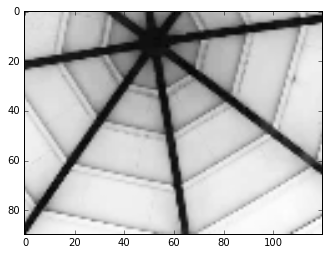

In [3]:
import matplotlib.pyplot as mp

% matplotlib inline
show_frame(sample[0,:])

Delete the last frame:

In [4]:
last_frame = sample[249,:]
sample = sample[0:249,:]
np.shape(sample)

(249, 10800)

Initialize all the parameters and normilize given sample:

In [5]:
sample_max = sample[:,:].max()
sample_min = sample[:,:].min()
print(sample_min, sample_max)

18.0 192.0


In [6]:
N = sample.shape[0] # count of samples
D = sample.shape[1] # dimensionality of observed space
Q = 20 # dimensionality of observed space

X = np.zeros((N,Q)) # Initialize the latent variable

#normilizing data:
sample_mean = np.mean(sample)
sample_std = np.std(sample)
sample_norm = (sample - sample_mean)/sample_std # normalization

print(sample_norm)
print(sample_mean)
print(sample_std)

[[ 0.71623249  0.77006809  0.8239037  ...,  1.38917753  1.38917753
   1.38917753]
 [ 0.74315029  0.77006809  0.79698589 ...,  1.36225973  1.38917753
   1.33534193]
 [ 0.77006809  0.77006809  0.74315029 ...,  1.33534193  1.38917753
   1.38917753]
 ..., 
 [ 0.20479425  0.17787645  0.17787645 ...,  1.25458852  1.30842413
   1.30842413]
 [ 0.09712305  0.07020524  0.01636964 ...,  1.25458852  1.30842413
   1.30842413]
 [ 0.01636964 -1.03342463 -2.19089011 ...,  1.25458852  1.30842413
   1.30842413]]
128.391865611
37.150136071


Define combined kernel using GPy library:

In [7]:
import GPy

kernel = GPy.kern.Linear(Q,ARD=True)+GPy.kern.RatQuad(Q,ARD=True)+GPy.kern.MLP(Q,ARD=True)
#kernel = GPy.kern.Linear(Q,ARD=True)+GPy.kern.RBF(Q,ARD=True)+GPy.kern.RatQuad(Q,ARD=True)+GPy.kern.MLP(Q,ARD=True)+GPy.kern.Matern52(Q,ARD=True)
#kernel = GPy.kern.RBF(Q,ARD=True)
m = GPy.models.GPLVM(sample_norm, input_dim=Q, kernel=kernel, init='PCA')

Optimization of the model using SCG (Warning! Minimum value for max_iters is 100, for 10000 it takes around 1 hour to perform optimization)

In [8]:
m.optimize(messages=True, optimizer = 'SCG',max_iters=1000)

Extract latent X from the model:

In [9]:
X = m.X
print(X)

  index      |  GPLVM.latent_mean  |  constraints  |  priors
  [0 0]      |         1.61164112  |               |        
  [0 1]      |        -1.02438122  |               |        
  [0 2]      |         1.19993317  |               |        
  [0 3]      |        -0.58235600  |               |        
  [0 4]      |         1.47913596  |               |        
  [0 5]      |        -0.85201481  |               |        
  [0 6]      |         1.46367792  |               |        
  [0 7]      |        -1.22172256  |               |        
  [0 8]      |        -0.92450896  |               |        
  [0 9]      |         1.17991957  |               |        
  [ 0 10]    |        -0.86385668  |               |        
  [ 0 11]    |         1.12662822  |               |        
  [ 0 12]    |        -0.49839091  |               |        
  [ 0 13]    |         1.46418302  |               |        
  [ 0 14]    |        -0.34220533  |               |        
  [ 0 15]    |         1

Plot first 5 values to visualize:

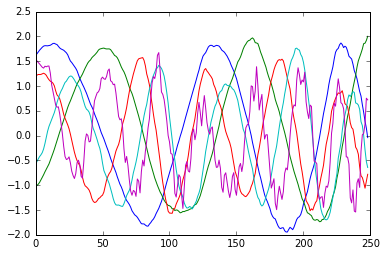

In [10]:
mp.plot(X[:,0:5])

Extract kernel matrix:

In [11]:
Kx = kernel.K(X[0:N-1])
print(Kx)

[[ 1.20001127  1.19739347  1.18874486 ...,  0.30622721  0.28131501
   0.26366804]
 [ 1.19739347  1.20043918  1.19697522 ...,  0.30872259  0.28291939
   0.2646498 ]
 [ 1.18874486  1.19697522  1.20083003 ...,  0.31246986  0.28572523
   0.26684646]
 ..., 
 [ 0.30622721  0.30872259  0.31246986 ...,  1.19601163  1.15240352
   1.08619568]
 [ 0.28131501  0.28291939  0.28572523 ...,  1.15240352  1.19615085
   1.15473842]
 [ 0.26366804  0.2646498   0.26684646 ...,  1.08619568  1.15473842
   1.19688117]]


Function to predict new artificial frame using mean prediction method:

In [12]:
def predict_new_latent_frame(N,X,kern,Kx_inv,X_old):
    
    k_x = kern.K(X[0:N-1],X_old)
    #k_xx = kern.K(X_old,X_old)

    meann = np.matmul(np.matmul(np.transpose(X[1:N]),Kx_inv),k_x).flatten()
    #cov = (k_xx - np.matmul(np.matmul(np.transpose(k_x),Kx_inv),k_x)) * np.eye(Q)
    
    #R = np.random.multivariate_normal(meann,cov)
    R = meann
    
    return R

Perform prediciton of new X:

In [13]:
N_synt = N+1  # generate one frame more to compare it with dropped one
X_synt = np.zeros((N_synt,Q))
X_last = X[N-1:N]
Kx_inv = np.linalg.inv(Kx)

for i in range(N_synt):
    X_synt[i,:] = predict_new_latent_frame(N,X,kernel,Kx_inv,X_last.reshape(1,Q))
    X_last = X_synt[i,:]
    
print(X_synt)

[[-0.22766998  1.98745323 -0.67525376 ..., -2.73062827  0.32233882
  -0.27900054]
 [-0.38871814  1.94135855 -0.57917107 ..., -1.97188538  0.51289385
  -0.74985659]
 [-0.5358671   1.89781665 -0.45227168 ..., -1.52694013  0.72436126
  -1.19892304]
 ..., 
 [ 1.13951856  1.38910495 -0.28320413 ...,  1.17747532 -1.01880299
   0.82734559]
 [ 1.00976857  1.51204802 -0.38684956 ...,  0.47004176 -1.87909571
   0.63741794]
 [ 0.88328057  1.58824315 -0.64304803 ..., -0.21467501 -1.96930346
  -0.1267907 ]]


Plot of new X:

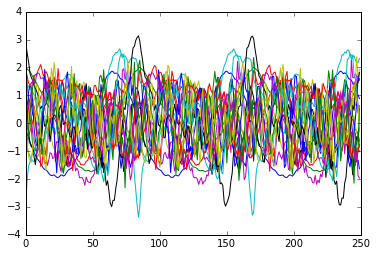

In [14]:
mp.plot(X_synt)

Now perform syntesis of new dinamic texture by mean prediction

In [15]:
Y_synt = np.zeros((N_synt,D))

Ky = kernel.K(X)
Ky_inv = np.linalg.inv(Ky)
Y_t = np.transpose(sample_norm)
k_y = kernel.K(X,X_synt)

meann = np.matmul(np.matmul(Y_t,Ky_inv),k_y)

Y_synt = np.transpose(meann)
    
print(Y_synt)

[[-0.09209513 -1.22546071 -2.52706871 ...,  1.27332203  1.3032839
   1.30582514]
 [-0.27406001 -1.04310212 -2.03857758 ...,  1.28985384  1.29941908
   1.30766377]
 [-0.7209757  -1.33342971 -2.15965489 ...,  1.29577137  1.30032183
   1.32256784]
 ..., 
 [ 0.47259099  0.47393456  0.50089242 ...,  1.33534863  1.33541086
   1.33546305]
 [ 0.41599484  0.4434006   0.47050289 ...,  1.33531216  1.33517395
   1.3352612 ]
 [ 0.36470511  0.39230241  0.41855579 ...,  1.33559682  1.33568658
   1.33563232]]


Display first frame:

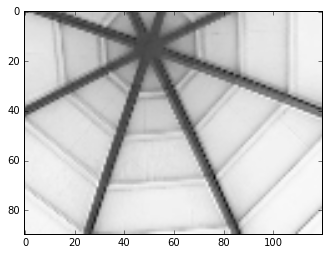

In [16]:
show_frame(Y_synt[0,:])

Denormalization:

In [17]:
Y_synt_denorm = sample_std * Y_synt + sample_mean
max = Y_synt_denorm[:,:].max()
min = Y_synt_denorm[:,:].min()
print(min, max)
print(sample_min,sample_max)

1.48829334885 189.702375129
18.0 192.0


In [18]:
sample_mean2 = np.mean(Y_synt_denorm)
sample_std2 = np.std(Y_synt_denorm)

print(sample_mean,sample_std)
print(sample_mean2,sample_std2)

128.391865611 37.150136071
126.728096166 37.6102052225


Compare missing frame and predicted one:

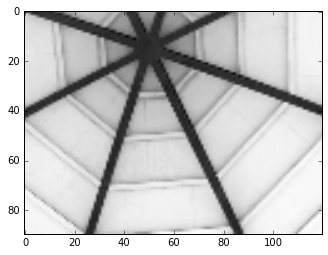

In [19]:
show_frame(last_frame)

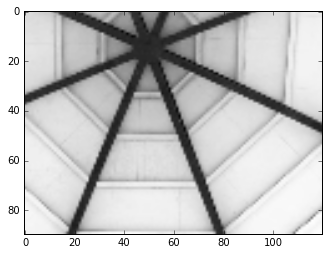

In [20]:
last_frame_pred = Y_synt_denorm[N,:]
show_frame(last_frame_pred)

Mean Sqare Error:

In [21]:
(1/D)*((last_frame - last_frame_pred)**2).sum()

1213.4507252301323

Absolute difference:

18.9650231295
5.12446700895e-05 120.445054952


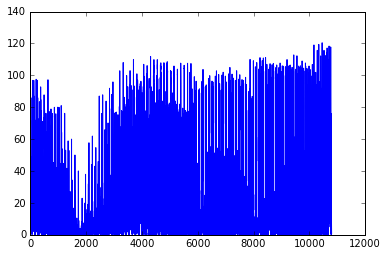

In [22]:
dif = abs(last_frame - last_frame_pred)
print(np.mean(dif))
print(dif.min(), dif.max())
mp.plot(dif)

Finally, save synthesized video:

In [ ]:
cap = cv2.VideoCapture(0)
fourcc = cv2.VideoWriter_fourcc(*'DIB ')
#fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('data\out_misframe.avi',fourcc, 25.0, (w,h))

for i in range(N_synt):
    print(i)
    frame = Y_synt_denorm[i,:].reshape((h,w)).astype(int)
    max = frame.max()
    min = frame.min()
    frame = (255/(max - min))*(frame - min)    
    img = np.zeros((90,120,3), np.uint8)
    img[:,:,0] = frame
    img[:,:,1] = frame
    img[:,:,2] = frame
    out.write(img)

cap.release()
out.release()
cv2.destroyAllWindows()
print('Done!')